#Imports

In [ ]:
import numpy as np
from tensorflow import keras
import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy import interpolate
import random
from sklearn.preprocessing import StandardScaler , MinMaxScaler
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/Thesis/'

Mounted at /content/drive


#Armmodel

##Virtual torque calc

In [ ]:
#length of lower and upper arm in m

class ArmModel:
  def __init__(self, l_upper_arm , l_lower_arm):
    self.l_upper_arm = l_upper_arm
    self.l_lower_arm = l_lower_arm

#defines the relationship between the joint angles  (theta1 is the shoulder, theta2 is elbow) and the end effector (weight)
  def jacobian_matrix(self,theta1,theta2):
    J = np.array([[-self.l_upper_arm *np.sin(theta1) - np.sin(theta1) - self.l_lower_arm * np.sin(theta1 + theta2),   -self.l_lower_arm * np.sin(theta1 + theta2)],

                  [-self.l_upper_arm * np.cos(theta1) + self.l_lower_arm * np.cos(theta1 + theta2),     self.l_lower_arm* np.cos(theta1 + theta2)]]
                  )
    return J

  def calc_torque(self, theta1, theta2, end_effector_force):
    torques_list = []
    J = self.jacobian_matrix(theta1, theta2)
    torques = np.dot(J.T, end_effector_force)
    torques_list.append(torques)

##simplified modell

In [ ]:
class ArmModel_simple:
  def __init__(self, l_lower_arm):
    self.l_lower_arm = l_lower_arm

  def calculate_force(self, weight, combined_angle):
    weight_in_newtons = weight * 9.80665
    torque = weight_in_newtons * self.l_lower_arm

    force = torque * 1/(-self.l_lower_arm * math.sin(combined_angle))

    return force




#Data import + Filtering + Segmenting (if by xsense markers: List-List-Npy)


In [ ]:
#For the shoulder: T1=(t1-t2)+(t5-t6) t1 is mono-articular biceps bracii, t2   mono-artiuclar triceps, t4 is bi-articular biceps , t5 is bi articular triceps
#For the elbow: T2=(t3-t4)+(t5-t6) t3 is mono-articular biceps bracii, t2 is mono-articular tricpes, t4 is bi-articular biceps , t5 is bi articular triceps

In [ ]:

#Loads the elbow angle, shoulder angle and emg_triceps data into long 1xX arrays (37 shulder, 39 elbow | bic 3 , lat 4 , long 5. , medial 6)
def load_data(input):

  #Ha big chad xsense fajl

    Markers_df = pd.read_excel(input, sheet_name = "Markers")
    Angle_df = pd.read_excel(input, sheet_name="Joint Angles XZY")
    EMG_df = pd.read_excel(input, sheet_name="External Data")

    #Markers
    markers = Markers_df[["Frame"]]
    #IMU


    shoulder_angle = Angle_df[["Frame" , "Left Shoulder Flexion/Extension"]]
    elbow_angle = Angle_df[[ "Frame" , "Left Elbow Flexion/Extension"]]

    #EMG
    emg_bicep = EMG_df[["Frame" , "biceps"] ]
    emg_triceps_lateral = EMG_df[["Frame" , "triceps_lateral"]]
    emg_triceps_long = EMG_df[["Frame" , "triceps_long"]]
    emg_triceps_medial = EMG_df[["Frame" , "triceps_medial"]]

    return markers , shoulder_angle, elbow_angle, emg_bicep , emg_triceps_lateral , emg_triceps_long , emg_triceps_medial

###EMG filtering

In [ ]:
def filter(x, fs=2000):

  notch_freq = 50
  lowpass = 500 / (fs / 2)
  highpass = 30 / (fs / 2)
  b_bp, a_bp = signal.butter(6, [highpass, lowpass], btype='bandpass', analog=False)

  b_notch, a_notch = signal.iirnotch(notch_freq, Q=30, fs=fs)  #Q for selectivity

  # Apply the filters
  f_bp = signal.lfilter(b_bp, a_bp, x)
  f_x = signal.lfilter(b_notch, a_notch, f_bp)

  f_bp = signal.lfilter(b_bp, a_bp, x)
  f_x = signal.lfilter(b_notch, a_notch, f_bp)

  return f_x


###AutoSegment (markerekkel)

In [ ]:
def segment_via_markers(markers , shoulder , elbow , bicep , tri_lat , tri_long , tri_medial):
  l_all_segments = [ ]
  marker = np.array(markers)
  for i  in range(0, marker.size-1):
    ar_segments_imu = []
    ar_segments_emg = []
    l_segments_imu_and_emg = []
    start = marker[i]
    end = marker[i+1]

    #IMU

    #shoulder
    filtered_df = shoulder.query("Frame > @start and Frame <= @end")
    relevant_segments = np.array(filtered_df.iloc[:, 1])
    ar_segments_imu.append(relevant_segments)
    #elbow
    filtered_df = elbow.query("Frame > @start and Frame <= @end")
    relevant_segments = np.array(filtered_df.iloc[:, 1])
    ar_segments_imu.append(relevant_segments)

    ar_segments_imu = np.array(ar_segments_imu)
    l_segments_imu_and_emg.append(ar_segments_imu)

    #EMG

    #bicep
    filtered_df = bicep.query("Frame > @start and Frame <= @end")
    relevant_segments = np.array(filtered_df.iloc[:, 1])
    ar_segments_emg.append(relevant_segments)
    #tri_lat
    filtered_df = tri_lat.query("Frame > @start and Frame <= @end")
    relevant_segments = np.array(filtered_df.iloc[:, 1])
    ar_segments_emg.append(relevant_segments)
    #tri_long
    filtered_df = tri_long.query("Frame > @start and Frame <= @end")
    relevant_segments = np.array(filtered_df.iloc[:, 1])
    ar_segments_emg.append(relevant_segments)
    #tri_medial
    filtered_df = tri_medial.query("Frame > @start and Frame <= @end")
    relevant_segments = np.array(filtered_df.iloc[:, 1])
    ar_segments_emg.append(relevant_segments)


    ar_segments_emg = np.array(ar_segments_emg)
    l_segments_imu_and_emg.append(ar_segments_emg)

    #load all into a numpy array, pusback into a list and be happy its done :+)
    l_all_segments.append(l_segments_imu_and_emg)
  return l_all_segments




###Standart deviációs segment

In [ ]:
'''
def segment_std(data , magnitude_tocut):
  std_dev = np.std(data.iloc(:,1))

  for i in range(1, len(data)):
    while data.iloc(i,1) > std_dev*magnitude_tocut:
'''


'\ndef segment_std(data , magnitude_tocut):\n  std_dev = np.std(data.iloc(:,1))\n\n  for i in range(1, len(data)):\n    while data.iloc(i,1) > std_dev*magnitude_tocut:\n'

###main(Datathing)

In [ ]:
#light lifts

markers , shoulder , elbow , bicep , tri_lat , tri_long , tri_medial = load_data(folder_path+"Data/konnyu_emeles.xlsx")
bicep["biceps"] = filter(bicep["biceps"])
tri_lat["triceps_lateral"] = filter(tri_lat["triceps_lateral"])
tri_long["triceps_long"] = filter(tri_long["triceps_long"])
tri_medial["triceps_medial"] = filter(tri_medial["triceps_medial"])
segmented_parts_konnyuemeles = segment_via_markers(markers , shoulder , elbow , bicep , tri_lat , tri_long , tri_medial)



In [ ]:
#heavy lifts
segmented_parts_nehezemeles = []
for i in range(0, 6):
    filename = f"nehez_emeles_{i+1}_6.xlsx"
    markers, shoulder, elbow, bicep, tri_lat, tri_long, tri_medial = load_data(folder_path+"/Data/"+filename)
    bicep["biceps"] = filter(bicep["biceps"])
    tri_lat["triceps_lateral"] = filter(tri_lat["triceps_lateral"])
    tri_long["triceps_long"] = filter(tri_long["triceps_long"])
    tri_medial["triceps_medial"] = filter(tri_medial["triceps_medial"])
    segmented_parts_neheztmp = segment_via_markers(markers, shoulder, elbow, bicep, tri_lat, tri_long, tri_medial)
    segmented_parts_nehezemeles.extend(segmented_parts_neheztmp)

###Save it (into the npy savesfile)

In [ ]:
'''
##konnyu
flattened_data = np.concatenate([array for sublist in segmented_parts_konnyuemeles for array in sublist])
np.save('segmented_data_konnyuemeles.npy', flattened_data)

##nehez
flattened_data = np.concatenate([array for sublist in segmented_parts_nehezemeles for array in sublist])
np.save('segmented_data_nehezemeles.npy', flattened_data)'''

"\n##konnyu\nflattened_data = np.concatenate([array for sublist in segmented_parts_konnyuemeles for array in sublist])\nnp.save('segmented_data_konnyuemeles.npy', flattened_data)\n\n##nehez\nflattened_data = np.concatenate([array for sublist in segmented_parts_nehezemeles for array in sublist])\nnp.save('segmented_data_nehezemeles.npy', flattened_data)"

HA nem vagyok delulu, akkor van 2 lista-lista-npyarray, ami nehéz és könnyű mérések, azon belül  amérések maguk, és a imu és emg külön külön leválasztva

##Sampling

###(Def is 2kHz for EMG and 60Hz for IMU)

In [ ]:
def downsample(emg_data, original_fs, target_fs):

  #anti-aliasing filter
  nyq_orig = original_fs / 2
  cutoff_freq = target_fs / 2
  b, a = signal.butter(6, cutoff_freq / nyq_orig, btype='low')

  # Filter the EMG data
  filtered_data = signal.filtfilt(b, a, emg_data)

  # Decimation factor
  decimation_factor = int(original_fs / target_fs)

  # Decimate the filtered data (*axe slash*)
  downsampled_data = filtered_data[::decimation_factor]
  return downsampled_data


In [ ]:
def upsample(imu_angles: np.ndarray, original_sampling_rate: float, target_sampling_rate: float, interpolation_method: str = 'linear'):
    # Ensure the input is at least 2D (for single-axis data)
    if imu_angles.ndim == 1:
        imu_angles = imu_angles.reshape(1, -1)

    # Compute the number of samples in the original and upsampled signals
    num_original_samples = imu_angles.shape[1]
    num_upsampled_samples = int(num_original_samples * target_sampling_rate / original_sampling_rate)

    # Generate the original and upsampled time indices
    original_indices = np.linspace(0, num_original_samples - 1, num=num_original_samples)
    upsampled_indices = np.linspace(0, num_original_samples - 1, num=num_upsampled_samples)

    # Perform the interpolation
    interpolator = interpolate.interp1d(original_indices, imu_angles, kind=interpolation_method, axis=1)
    upsampled_imu_angles = interpolator(upsampled_indices)

    return upsampled_imu_angles

In [ ]:
def upsample_and_downsample(data , orig_up, des_up, orig_down , des_down):
  tmp_list = []

  for sample in data:
    #testing
  #for i in range(0, 1):
    for_stacking = []
    tmp_emg = []
    tmp_imu = []
    emg_array = []
    imu_array = []
    #EMG

    for y in range(0 , len(sample[1])):
      emg = []
      emg = downsample(sample[1][y], orig_down , des_down)
      emg = np.array(emg)
      tmp_emg.append(emg)
    emg_array = np.vstack(tmp_emg)
      #IMU
    for x in range(0 , len(sample[0])):
      imu = []
      imu = upsample(sample[0][x], orig_up, des_up)
      imu = imu.reshape(-1)
      tmp_imu.append(imu)
    imu_array = np.vstack(tmp_imu)


    if len(imu_array[1]) > len(emg_array[1]):
        imu_array = imu_array[:, :len(emg_array[1])]
    elif len(emg_array[1]) > len(imu_array[1]):
        emg_array = emg_array[:, :len(imu_array[1])]

    for_stacking.append(emg_array)
    for_stacking.append(imu_array)
    combined_data = np.vstack(for_stacking)
    tmp_list.append(combined_data)
  return tmp_list


   #1st is IMU , sencond is EMG


##main(sampling)

In [ ]:
new_light = upsample_and_downsample(segmented_parts_konnyuemeles , 60 , 1000 , 2000 , 1000)
new_heavy = upsample_and_downsample(segmented_parts_nehezemeles , 60 , 1000 , 2000 , 1000)

##Calc the torque

In [ ]:
#GIVE DATA IN A FOR LOOP |||shoulder and elbow in order
def calc_simple_torque(data , weight):
  Arm_model_simple = ArmModel_simple(0.3) # lower arm length in m
  imu_data = data[4:]
  torques = []
  for j in range(0 , len(imu_data[1])):
    shoulder_angle = imu_data[0][j]
    elbow_angle = imu_data[1][j]
    estimated_force = Arm_model_simple.calculate_force(weight , (shoulder_angle+elbow_angle))
    torques.append(estimated_force)

  return torques

In [ ]:
new_light_w_torque = []
new_heavy_w_torque = []
for sample in new_light:
  torques = calc_simple_torque(sample, 2)  # Calculate torques for the sample
  torques = np.array(torques)  # Convert torques to NumPy array
  torques = torques.reshape(1, -1)
  combined_data = np.concatenate((sample[:4], torques) , axis = 0)  # Combine EMG and torque data
  new_light_w_torque.append(combined_data)

for sample in new_heavy:
  torques = calc_simple_torque(sample, 8)  # Calculate torques for the sample
  torques = np.array(torques)  # Convert torques to NumPy array
  torques = torques.reshape(1, -1)
  combined_data = np.concatenate((sample[:4], torques) , axis = 0)  # Combine EMG and torque data
  new_heavy_w_torque.append(combined_data)


#Neural Network


##Normalisation(emg and other)

In [ ]:
#BAD
'''
#Takes the elements of the list, seperates emg and other, normalises adds them back togather and SKADOOOSH
def preprocess_emg_imu_data(data):


  # Separate EMG and IMU data
  emg_data = data[:4]
  imu_data = data[4:]

  # Standardize EMG data
  normalized_emg = [StandardScaler().fit_transform(d.reshape(-1, 1))[:, 0] for d in emg_data]

  # Standardize IMU data
  normalized_imu = [StandardScaler().fit_transform(d.reshape(-1, 1))[:, 0] for d in imu_data]

  # Combine normalized data
  #ugly way
  normalized_data = np.concatenate((normalized_emg, normalized_imu), axis=0)

  return normalized_data
'''



In [ ]:
#BAD
'''
normalized_light = []
normalized_heavy = []
for i in range(0, len(new_light)):
  normalized_light.append(preprocess_emg_imu_data(new_light[i]))
for j in range(0, len(new_heavy)):
  normalized_heavy.append(preprocess_emg_imu_data(new_heavy[j]))

normalized_light_w_torque = []
normalized_heavy_w_torque = []
for i in range(0, len(new_light_w_torque)):
  normalized_light_w_torque.append(preprocess_emg_imu_data(new_light_w_torque[i]))
for j in range(0, len(new_heavy_w_torque)):
  normalized_heavy_w_torque.append(preprocess_emg_imu_data(new_heavy_w_torque[j]))
'''

In [ ]:
#fixing my mistake ||| a combined datan csinálok mindent, és a light+hea
def normaliser(light , heavy):

  #setup the Standardiser

  combined_light = np.hstack(light)
  size_light = len(combined_light[2])

  combined_heavy = np.hstack(heavy)
  size_heavy = len(combined_heavy[2])



  tmp = []
  tmp.append(combined_light)
  tmp.append(combined_heavy)
  all_combined = np.hstack(tmp)

  #Do the normalisation
  all_combined = np.swapaxes(all_combined, 0, 1)

   # Standardize data
  scaler_std = StandardScaler()
  std_combined = scaler_std.fit_transform(all_combined)

  # Apply MinMaxScaler to normalized data
  scaler_norm = MinMaxScaler(feature_range=(-1, 1))
  norm_combined = scaler_norm.fit_transform(std_combined)

  # swap back to original form
  norm_combined = np.swapaxes(norm_combined, 0 ,1)



  #Segment it back into segments
  norm_light = norm_combined[:, :size_light]
  norm_heavy = norm_combined[:, size_light:]

  #lights
  resegmented_lights = []
  prev_length_l = 0
  for i in range(0, len(light)):
    sample = light[i]
    cucc = norm_light[: , prev_length_l:(len(sample[1]+prev_length_l))]
    resegmented_lights.append(cucc)

  #heavy

  resegmented_heavy = []
  prev_length_h = 0
  for i in range(0, len(heavy)):
    sample = heavy[i]
    cucc = norm_heavy[: , prev_length_h:(len(sample[1]+prev_length_h))]
    resegmented_heavy.append(cucc)

  return resegmented_lights , resegmented_heavy





Text(0.5, 1.0, 'norm_heavy')

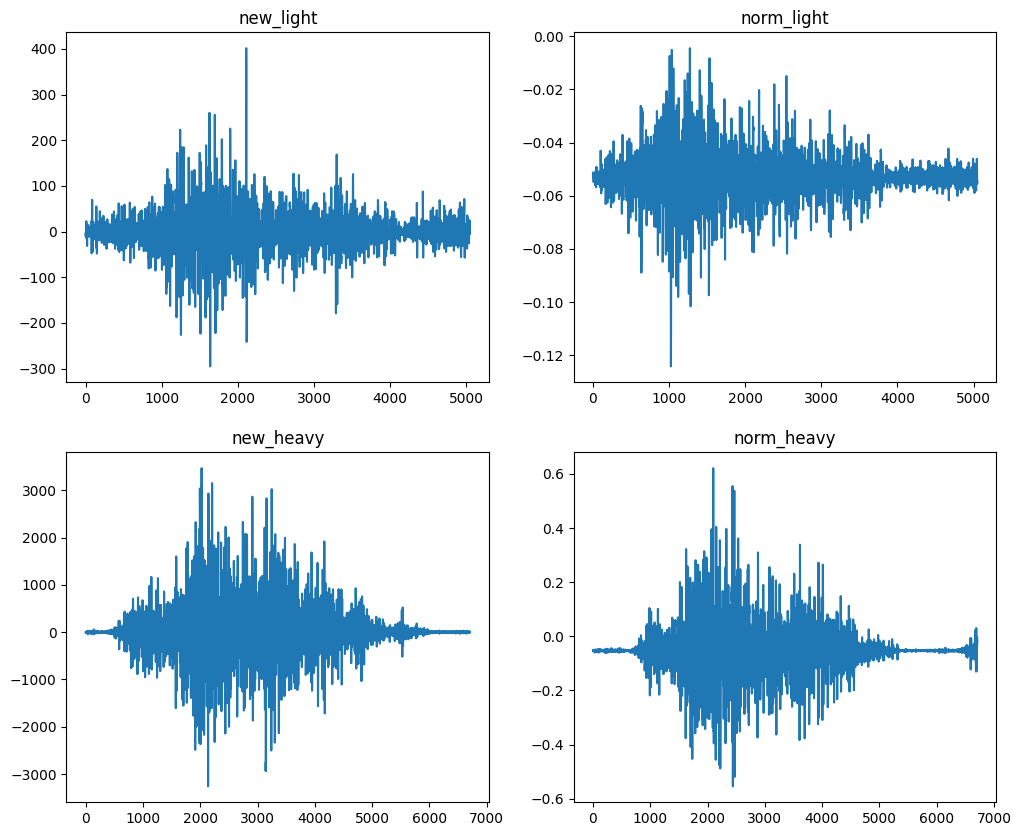

In [ ]:
normalized_light, normalized_heavy = normaliser(new_light, new_heavy)
normalized_light_w_torque , normalized_heavy_w_torque = normaliser (new_light_w_torque , new_heavy_w_torque)

#furi mert eltolja 0áról a dolgokat

plt.figure(figsize=(12, 10))
plt.subplot(2,2,1)
plt.plot(new_light[1][0])
plt.title("new_light")
plt.subplot(2,2,2)
plt.plot(normalized_light[1][0])
plt.title("norm_light")
plt.subplot(2,2,3)
plt.plot(new_heavy[1][0])
plt.title("new_heavy")
plt.subplot(2,2,4)
plt.plot(normalized_heavy[1][0])
plt.title("norm_heavy")


In [ ]:
import numpy as np

# Assuming normalized_light is a list of NumPy arrays
shortest_length = np.min([arr.shape[1] for arr in normalized_light])  # Get lengths
shortest_array = [arr for arr in normalized_light if arr.shape[1] == shortest_length][0]

print(f"Shortest array has length: {shortest_length}")
# Access the shortest array using shortest_array


Shortest array has length: 4532


##Label them all + create a test and train set

In [ ]:
def label (light , heavy , train_size=0.2, shuffle =True):
    labels1 = [0] * len(light) # 0 = light
    labels2 = [1] * len(heavy) # 1 = heavy

    combined_data = list(zip(light + heavy, labels1 + labels2))

    if shuffle:
        random.shuffle(combined_data)

    split_index = int(len(combined_data) * (1 - train_size))

    train_data, test_data = combined_data[:split_index], combined_data[split_index:]

    train_list, train_labels = zip(*train_data)
    test_list, test_labels = zip(*test_data)

    return list(train_list), list(train_labels), list(test_list), list(test_labels)

In [ ]:
print(len(normalized_light))
print(len(normalized_heavy))

36
34


##main(labeling)

Training Set: 54
Test Set: 14
Torque Training Set: 54
Torque Test Set: 14


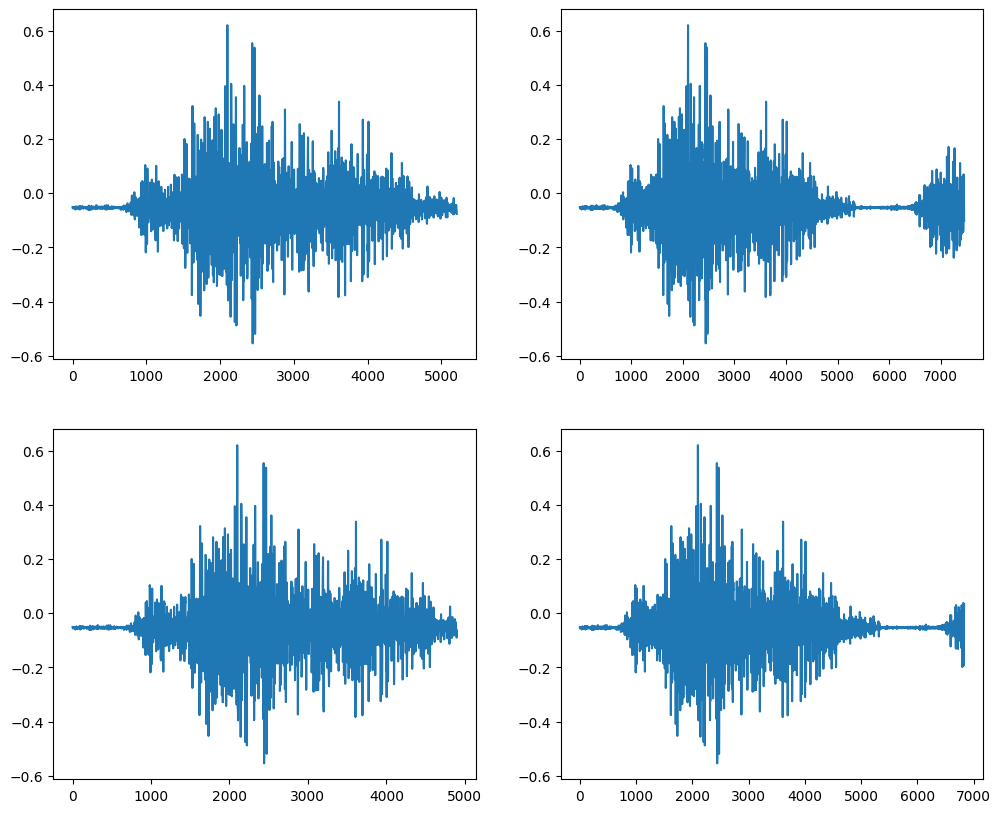

In [ ]:
train_set, train_labels , test_set, test_labels = label(normalized_light[:34] , normalized_heavy)
print("Training Set:", len(train_set))
print("Test Set:", len(test_set))

train_set_torque , train_labels_torque , test_set_torque , test_labels_torque = label(normalized_light_w_torque[:34] , normalized_heavy_w_torque)
print("Torque Training Set:", len(train_set_torque))
print("Torque Test Set:", len(test_set_torque))


plt.figure(figsize=(12, 10))
plt.subplot(2,2,1)
plt.plot(train_set[0][0])
plt.subplot(2,2,2)
plt.plot(test_set[0][0])
plt.subplot(2,2,3)
plt.plot(train_set_torque[0][0])
plt.subplot(2,2,4)
plt.plot(test_set_torque[0][0])


## *Magic*

In [ ]:
def get_next_batch(data, label, batch_number):
  assert(len(data) == len(label))

  used_in_batch = random.sample(range(len(data)), batch_number)
  samples = []
  labels = []
  for i in used_in_batch:
    samples.append(data[i])
    labels.append(label[i])

  return samples, labels

##Gated CNN modell def

In [ ]:
class GatedConvNet(nn.Module):
    def __init__(self, input_size, num_filters, kernel_size, output_size):
        super(GatedConvNet, self).__init__()
        self.conv = nn.Conv1d(input_size, num_filters, kernel_size=kernel_size, padding=1)
        self.gate = nn.Conv1d(input_size, num_filters, kernel_size=kernel_size, padding=1)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(num_filters, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x is a tensor with shape (batch_size, sequence_length, input_size)
        conv_out = self.conv(x)
        gate_out = torch.sigmoid(self.gate(x))  # Apply sigmoid for gating
        out = conv_out * gate_out  # Element-wise multiplication
        out = self.pool(out)
        out = out.squeeze(1)  # Remove dimension for single output
        out = self.fc(out)
        out = self.sigmoid(out)

        return out

##Normal CNN def

In [ ]:
'''
# Model definition
model = nn.Sequential(
    nn.Conv1d(1, 32, kernel_size=3),
    nn.ReLU() ,
    nn.MaxPool1d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(64, 1),
    nn.Sigmoid()  # Assuming binary classification
)

'''

'\n# Model definition\nmodel = nn.Sequential(\n    nn.Conv1d(1, 32, kernel_size=3),\n    nn.ReLU() ,\n    nn.MaxPool1d(kernel_size=2),\n    nn.Flatten(),\n    nn.Linear(64, 1),\n    nn.Sigmoid()  # Assuming binary classification\n)\n\n'

##Training loop + Trinkets

In [ ]:
# train parameters
epochs=300
batch_size = 32
lr=0.005
num_filters= 32
kernel_size = 3

In [ ]:
model = GatedConvNet(input_size=5, num_filters=num_filters, kernel_size=kernel_size, output_size=1) #Change based on Emg-imu or Emg-Torque


#check for CUDAA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.BCELoss()

#Optimiser + scheduler
optimizer = torch.optim.Adam(model.parameters(), lr= lr, weight_decay=0.2)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)

model = model.to(device)
criterion= criterion.to(device)

In [ ]:
print(model)

GatedConvNet(
  (conv): Conv1d(5, 16, kernel_size=(9,), stride=(1,), padding=(1,))
  (gate): Conv1d(5, 16, kernel_size=(9,), stride=(1,), padding=(1,))
  (pool): AdaptiveMaxPool1d(output_size=1)
  (fc): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


##Train with IMU

In [ ]:
import datetime
timestamp = datetime.datetime.now().strftime("%Y-%M-%D_%H-%M")
filename = f"Paremeters_of_lr{lr}_epochs{epochs}_batch{batch_size}_{timestamp}"
print(f"Paremeters_of_TorqueNN_lr{lr}_epochs{epochs}_batch{batch_size}_{timestamp}")

#to store the losses and learning rates
losses = []
lr_s = []

counter = 0
threshold = 60
#keep track of best losses
best_val_loss = float('inf')
validation_loss = []

# Train the model with batching and loss printing
for epoch in range(epochs):
  epoch_loss = 0 # init for the current epoch
  model.train()


  # Create batches
  batch_data , batch_labels = get_next_batch(train_set , train_labels , batch_size)

  #Turn everything to tensors
  #Move to Budha, >> C(o)u(l)da << Woulda
  batch_data = [torch.from_numpy(data_sample).to(device=device, dtype=torch.float32) for data_sample in batch_data]
  batch_labels_tensor = torch.tensor(batch_labels, dtype=torch.long)
  batch_labels = batch_labels_tensor.to(device = device , dtype = torch.float32)

  # Forward pass the data
  data_pred = []  # Empty list to store predictions
  for data_sample in batch_data:
    # data_sample is a single tensor from the batch
    data_sample = data_sample.to(device)
    prediction = model(data_sample)  # Pass the single tensor to the model
    data_pred.append(prediction)

  #Compute loss
  data_pred_tensor = torch.cat(data_pred, dim=0)
  loss = criterion(data_pred_tensor , batch_labels)
  epoch_loss += loss.item()

  #Backward pass
  optimizer.zero_grad()
  loss.backward()
  nn.utils.clip_grad_norm_(model.parameters(), 0.1)
  optimizer.step()

  #Scheduler step
  scheduler.step(loss)

  # Validation step
  model.eval()
  val_data , val_labels = get_next_batch(test_set, test_labels, 14)
  with torch.no_grad():  # Deactivate gradient calculation for validation
    val_loss = 0
    val_label = torch.tensor(val_labels, dtype=torch.float)
    for val_data_sample, val_label in zip(val_data, val_label):
      # Prepare validation data (similar to training)
      val_label = val_label.unsqueeze(0)
      val_sample = torch.from_numpy(val_data_sample).to(device, dtype=torch.float32)

      # Forward pass on validation data
      val_pred = model(val_sample)
      # Calculate and accumulate validation loss
      v_loss  = criterion(val_pred, val_label)
      val_loss += v_loss.item()

    # Track best validation loss for early stopping
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      counter = 0
      torch.save(model.state_dict(), f'best_model_imu_wval.pth')
    else:
      counter += 1
    if epoch % 10 == 0:
      validation_loss.append(val_loss)
      print("Epoch {}: Validation Loss: {:.4f} , learning rate: {}".format(epoch, val_loss , scheduler.get_last_lr()[0]))

  if counter >= threshold:
      print(f'Early stopping at epoch {epoch}')
      break

Paremeters_of_TorqueNN_lr0.005_epochs300_batch32_2024-30-05/20/24_18-30
Epoch 0: Validation Loss: 9.3914 , learning rate: 0.005
Epoch 10: Validation Loss: 8.8771 , learning rate: 0.005
Epoch 20: Validation Loss: 9.0205 , learning rate: 0.005
Epoch 30: Validation Loss: 9.3183 , learning rate: 0.0025
Epoch 40: Validation Loss: 9.5150 , learning rate: 0.00125
Epoch 50: Validation Loss: 9.5956 , learning rate: 0.000625
Epoch 60: Validation Loss: 9.6243 , learning rate: 0.0003125
Early stopping at epoch 69


In [ ]:
 import datetime
timestamp = datetime.datetime.now().strftime("%Y-%M-%D_%H-%M")
filename = f"Paremeters_of_lr{lr}_epochs{epochs}_batch{batch_size}_{timestamp}"
print(f"Paremeters_of_IMUNN__lr{lr}_epochs{epochs}_batch{batch_size}_{timestamp}")

#to store the losses and learning rates
losses = []
lr_s = []

counter = 0
threshold = 40
#keep track of best losses
best_train_loss = float('inf')
val_loss = []
# Train the model with batching and loss printing
for epoch in range(epochs):
  epoch_loss = 0 # init for the current epoch
  model.train()


  # Create batches
  batch_data , batch_labels = get_next_batch(train_set , train_labels , batch_size)

  #Turn everything to tensors
  #Move to Budha, >> C(o)u(l)da << Woulda
  batch_data = [torch.from_numpy(data_sample).to(device=device, dtype=torch.float32) for data_sample in batch_data]
  batch_labels_tensor = torch.tensor(batch_labels, dtype=torch.long)
  batch_labels = batch_labels_tensor.to(device = device , dtype = torch.float32)

  # Forward pass the data
  data_pred = []  # Empty list to store predictions
  for data_sample in batch_data:
    # data_sample is a single tensor from the batch
    data_sample = data_sample.to(device)
    prediction = model(data_sample)  # Pass the single tensor to the model
    data_pred.append(prediction)

  #Compute loss
  data_pred_tensor = torch.cat(data_pred, dim=0)
  loss = criterion(data_pred_tensor , batch_labels)
  epoch_loss += loss.item()

  #Backward pass
  optimizer.zero_grad()
  loss.backward()
  nn.utils.clip_grad_norm_(model.parameters(), 0.1)
  optimizer.step()

  #Scheduler step
  scheduler.step(loss)


  #Save params if its a better train
  if loss< best_train_loss:
    best_train_loss = loss
    counter = 0
    torch.save(model.state_dict(), f'best_model_imu_noval.pth')
  else:
    counter +=1
  if epoch % 10 == 0:
    losses.append(epoch_loss)
    print("Epoch {}: Training Loss: {:.4f} , learning rate: {}".format(epoch, epoch_loss , scheduler.get_last_lr()[0]))


    if counter >= threshold:
        print(f'Early stopping at epoch {epoch}')
        break

Paremeters_of_IMUNN__lr0.005_epochs300_batch32_2024-32-05/20/24_18-32
Epoch 0: Training Loss: 0.7043 , learning rate: 0.005
Epoch 10: Training Loss: 0.6733 , learning rate: 0.005
Epoch 20: Training Loss: 0.6587 , learning rate: 0.005
Epoch 30: Training Loss: 0.6604 , learning rate: 0.0025
Epoch 40: Training Loss: 0.6602 , learning rate: 0.0025
Epoch 50: Training Loss: 0.6617 , learning rate: 0.00125
Epoch 60: Training Loss: 0.6646 , learning rate: 0.000625
Epoch 70: Training Loss: 0.6563 , learning rate: 0.0003125
Epoch 80: Training Loss: 0.6564 , learning rate: 0.0003125
Epoch 90: Training Loss: 0.6593 , learning rate: 0.00015625
Epoch 100: Training Loss: 0.6592 , learning rate: 0.00015625
Epoch 110: Training Loss: 0.6622 , learning rate: 7.8125e-05
Epoch 120: Training Loss: 0.6685 , learning rate: 3.90625e-05
Epoch 130: Training Loss: 0.6622 , learning rate: 1.953125e-05
Epoch 140: Training Loss: 0.6622 , learning rate: 9.765625e-06
Early stopping at epoch 140


Train with torque

##torque w val

In [ ]:
import datetime
timestamp = datetime.datetime.now().strftime("%Y-%M-%D_%H-%M")
filename = f"Paremeters_of_lr{lr}_epochs{epochs}_batch{batch_size}_{timestamp}"
print(f"Paremeters_of_TorqueNN_lr{lr}_epochs{epochs}_batch{batch_size}_{timestamp}")

#to store the losses and learning rates
losses = []
lr_s = []

counter = 0
threshold = 60
#keep track of best losses
best_val_loss = float('inf')
validation_loss = []

# Train the model with batching and loss printing
for epoch in range(epochs):
  epoch_loss = 0 # init for the current epoch
  model.train()


  # Create batches
  batch_data , batch_labels = get_next_batch(train_set_torque , train_labels_torque , batch_size)

  #Turn everything to tensors
  #Move to Budha, >> C(o)u(l)da << Woulda
  batch_data = [torch.from_numpy(data_sample).to(device=device, dtype=torch.float32) for data_sample in batch_data]
  batch_labels_tensor = torch.tensor(batch_labels, dtype=torch.long)
  batch_labels = batch_labels_tensor.to(device = device , dtype = torch.float32)

  # Forward pass the data
  data_pred = []  # Empty list to store predictions
  for data_sample in batch_data:
    # data_sample is a single tensor from the batch
    data_sample = data_sample.to(device)
    prediction = model(data_sample)  # Pass the single tensor to the model
    data_pred.append(prediction)

  #Compute loss
  data_pred_tensor = torch.cat(data_pred, dim=0)
  loss = criterion(data_pred_tensor , batch_labels)
  epoch_loss += loss.item()

  #Backward pass
  optimizer.zero_grad()
  loss.backward()
  nn.utils.clip_grad_norm_(model.parameters(), 0.1)
  optimizer.step()

  #Scheduler step
  scheduler.step(loss)

  # Validation step
  model.eval()
  val_data , val_labels = get_next_batch(test_set_torque, test_labels_torque, 14)
  with torch.no_grad():  # Deactivate gradient calculation for validation
    val_loss = 0
    val_label = torch.tensor(val_labels, dtype=torch.float)
    for val_data_sample, val_label in zip(val_data, val_label):
      # Prepare validation data (similar to training)
      val_label = val_label.unsqueeze(0)
      val_sample = torch.from_numpy(val_data_sample).to(device, dtype=torch.float32)

      # Forward pass on validation data
      val_pred = model(val_sample)
      # Calculate and accumulate validation loss
      v_loss  = criterion(val_pred, val_label)
      val_loss += v_loss.item()

    # Track best validation loss for early stopping
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      counter = 0
      torch.save(model.state_dict(), f'best_model_torque_wval.pth')
    else:
      counter += 1
    if epoch % 10 == 0:
      validation_loss.append(val_loss)
      print("Epoch {}: Validation Loss: {:.4f} , learning rate: {}".format(epoch, val_loss , scheduler.get_last_lr()[0]))

  if counter >= threshold:
      print(f'Early stopping at epoch {epoch}')
      break

Paremeters_of_TorqueNN_lr0.005_epochs300_batch32_2024-35-05/20/24_19-35
Epoch 0: Validation Loss: 9.8481 , learning rate: 0.005
Epoch 10: Validation Loss: 9.7578 , learning rate: 0.005
Epoch 20: Validation Loss: 9.7333 , learning rate: 0.0025
Epoch 30: Validation Loss: 9.7271 , learning rate: 0.00125
Epoch 40: Validation Loss: 9.7282 , learning rate: 0.000625
Epoch 50: Validation Loss: 9.7296 , learning rate: 0.0003125
Epoch 60: Validation Loss: 9.7305 , learning rate: 0.00015625
Epoch 70: Validation Loss: 9.7309 , learning rate: 7.8125e-05
Epoch 80: Validation Loss: 9.7310 , learning rate: 3.90625e-05
Early stopping at epoch 87


##noval torque

In [ ]:
 import datetime
timestamp = datetime.datetime.now().strftime("%Y-%M-%D_%H-%M")
filename = f"Paremeters_of_lr{lr}_epochs{epochs}_batch{batch_size}_{timestamp}"
print(f"Paremeters_of_IMUNN__lr{lr}_epochs{epochs}_batch{batch_size}_{timestamp}")

#to store the losses and learning rates
losses = []
lr_s = []

counter = 0
threshold = 40
#keep track of best losses
best_train_loss = float('inf')

# Train the model with batching and loss printing
for epoch in range(epochs):
  epoch_loss = 0 # init for the current epoch
  model.train()


  # Create batches
  batch_data , batch_labels = get_next_batch(train_set_torque , train_labels_torque , batch_size)

  #Turn everything to tensors
  #Move to Budha, >> C(o)u(l)da << Woulda
  batch_data = [torch.from_numpy(data_sample).to(device=device, dtype=torch.float32) for data_sample in batch_data]
  batch_labels_tensor = torch.tensor(batch_labels, dtype=torch.long)
  batch_labels = batch_labels_tensor.to(device = device , dtype = torch.float32)

  # Forward pass the data
  data_pred = []  # Empty list to store predictions
  for data_sample in batch_data:
    # data_sample is a single tensor from the batch
    data_sample = data_sample.to(device)
    prediction = model(data_sample)  # Pass the single tensor to the model
    data_pred.append(prediction)

  #Compute loss
  data_pred_tensor = torch.cat(data_pred, dim=0)
  loss = criterion(data_pred_tensor , batch_labels)
  epoch_loss += loss.item()

  #Backward pass
  optimizer.zero_grad()
  loss.backward()
  nn.utils.clip_grad_norm_(model.parameters(), 0.1)
  optimizer.step()

  #Scheduler step
  scheduler.step(loss)


  #Save params if its a better train
  if loss< best_train_loss:
    best_train_loss = loss
    counter = 0
    torch.save(model.state_dict(), f'best_model_torque_noval.pth')
  else:
    counter +=1
  if epoch % 10 == 0:
    losses.append(epoch_loss)
    print("Epoch {}: Training Loss: {:.4f} , learning rate: {}".format(epoch, epoch_loss , scheduler.get_last_lr()[0]))


    if counter >= threshold:
        print(f'Early stopping at epoch {epoch}')
        break

Paremeters_of_IMUNN__lr0.005_epochs300_batch32_2024-26-05/20/24_19-26
Epoch 0: Training Loss: 0.6802 , learning rate: 0.005
Epoch 10: Training Loss: 0.6799 , learning rate: 0.005
Epoch 20: Training Loss: 0.6807 , learning rate: 0.0025
Epoch 30: Training Loss: 0.6819 , learning rate: 0.00125
Epoch 40: Training Loss: 0.6825 , learning rate: 0.000625
Epoch 50: Training Loss: 0.6833 , learning rate: 0.0003125
Early stopping at epoch 50


##show Loss stats

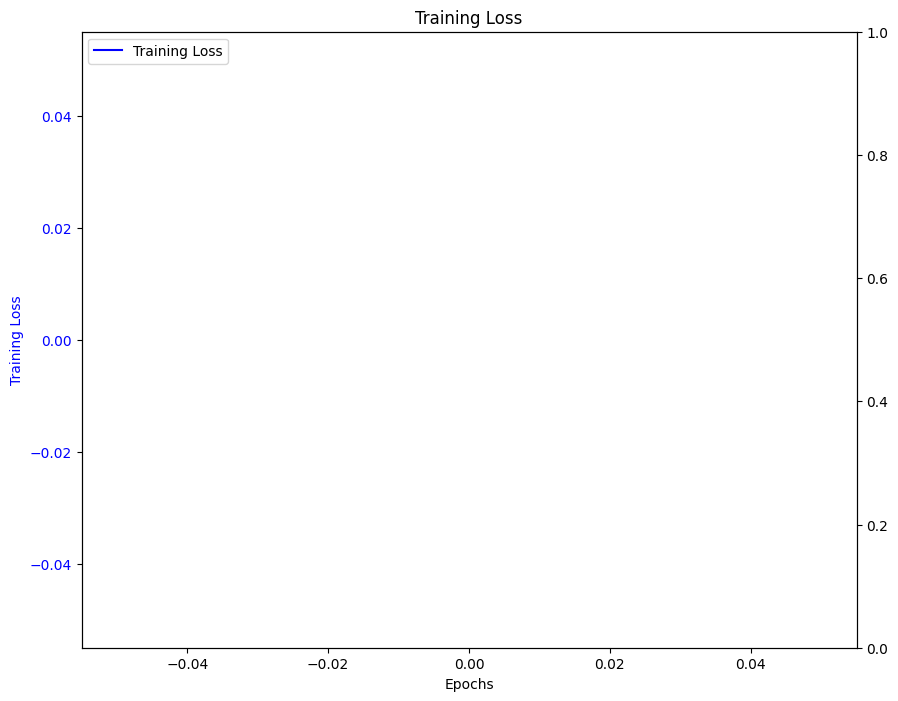

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 8))

# Plotting trimmed training loss on the primary y-axis (left)
ax1.plot(losses, label='Training Loss', color='blue')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Loss', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# Creating a secondary y-axis
ax2 = ax1.twinx()
plt.title('Training Loss')
plt.show()

##Load the model with the best params + set to eval

In [ ]:
model.eval()
#model.load_state_dict(torch.load('/content/best_model_imu_wval.pth', map_location=torch.device('cpu')))
model.load_state_dict(torch.load('/content/best_model_torque_noval.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

[1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.]
[array([0.5135322], dtype=float32), array([0.5135322], dtype=float32), array([0.4999249], dtype=float32), array([0.51362646], dtype=float32), array([0.4999286], dtype=float32), array([0.5135322], dtype=float32), array([0.49993354], dtype=float32), array([0.49976152], dtype=float32), array([0.49999374], dtype=float32), array([0.50002223], dtype=float32), array([0.5135322], dtype=float32), array([0.4999889], dtype=float32), array([0.50001097], dtype=float32), array([0.5135322], dtype=float32)]


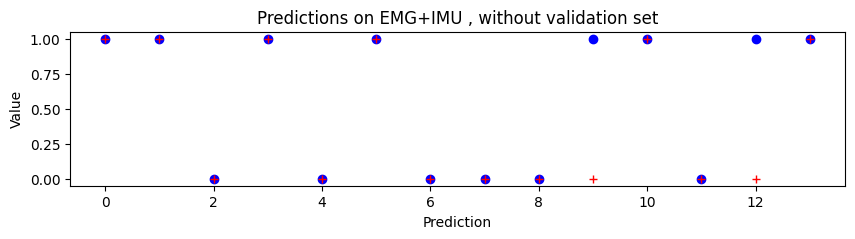

In [ ]:
# Create batches
#show_batch_data , show_batch_labels = get_next_batch(train_set , train_labels , 45)
show_batch_data , show_batch_labels = get_next_batch(test_set_torque , test_labels_torque , 14)


#Turn everything to tensors
#Move to Budha, >> C(o)u(l)da << Woulda
show_batch_data = [torch.from_numpy(data_sample).to(device=device, dtype=torch.float32) for data_sample in show_batch_data]
show_batch_labels_tensor = torch.tensor(show_batch_labels, dtype=torch.long)
show_batch_labels = show_batch_labels_tensor.to(device = device , dtype = torch.float32)


# Forward pass the data
show_data_pred = []  # Empty list to store predictions
for data_sample in show_batch_data:
  prediction = model(data_sample)  # Pass the single tensor to the model
  show_data_pred.append(prediction)


show_data_pred_np = []
for i in range(0 , len(show_data_pred)):
  tmp = show_data_pred[i].detach().cpu().numpy()
  show_data_pred_np.append(tmp)
show_batch_labels_np = show_batch_labels.detach().cpu().numpy()
print(show_batch_labels_np)
print(show_data_pred_np)
show_data_pred_np = np.round(show_data_pred_np, decimals=0)

fig, ax = plt.subplots(figsize=(10, 2))

ax.plot(show_data_pred_np , 'bo')
ax.plot(show_batch_labels_np, 'r+')
ax.set_xlabel('Prediction')
ax.set_ylabel('Value')
ax.set_title('Predictions on EMG+IMU , without validation set')

plt.show()


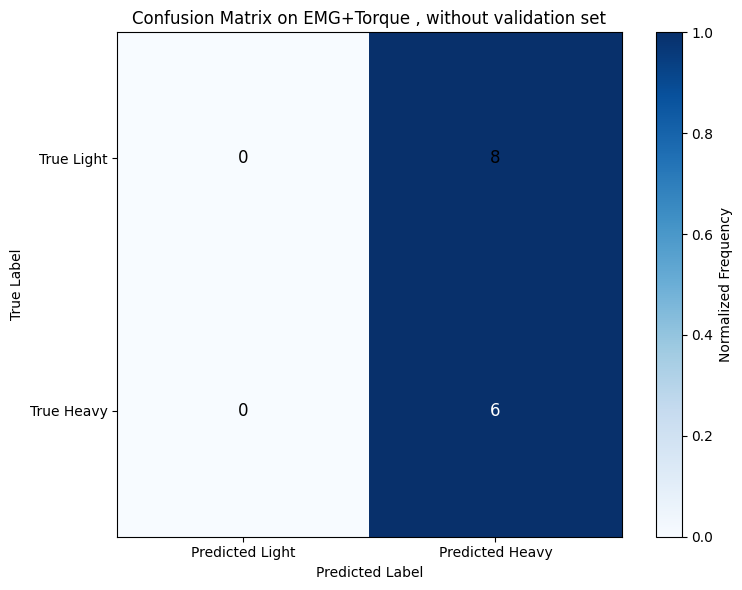

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Assuming you have true labels (y_true) and predicted labels (y_pred)
cm = confusion_matrix(show_batch_labels_np, show_data_pred_np)

# Normalize the confusion matrix for better visualization
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap using Matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(cm_norm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix on EMG+Torque , without validation set')
plt.colorbar(label='Normalized Frequency')
plt.xticks(range(2), ['Predicted Light', 'Predicted Heavy'])
plt.yticks(range(2), ['True Light', 'True Heavy'])
plt.text(0, 0, f'{cm[0,0]}', ha='center', va='center', fontsize=12, color='black')
plt.text(1, 0, f'{cm[0,1]}', ha='center', va='center', fontsize=12, color='black')
plt.text(0, 1, f'{cm[1,0]}', ha='center', va='center', fontsize=12, color='black')
plt.text(1, 1, f'{cm[1,1]}', ha='center', va='center', fontsize=12, color='white')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.grid(False)
plt.tight_layout()
plt.show()


##IMG generation for the pdf

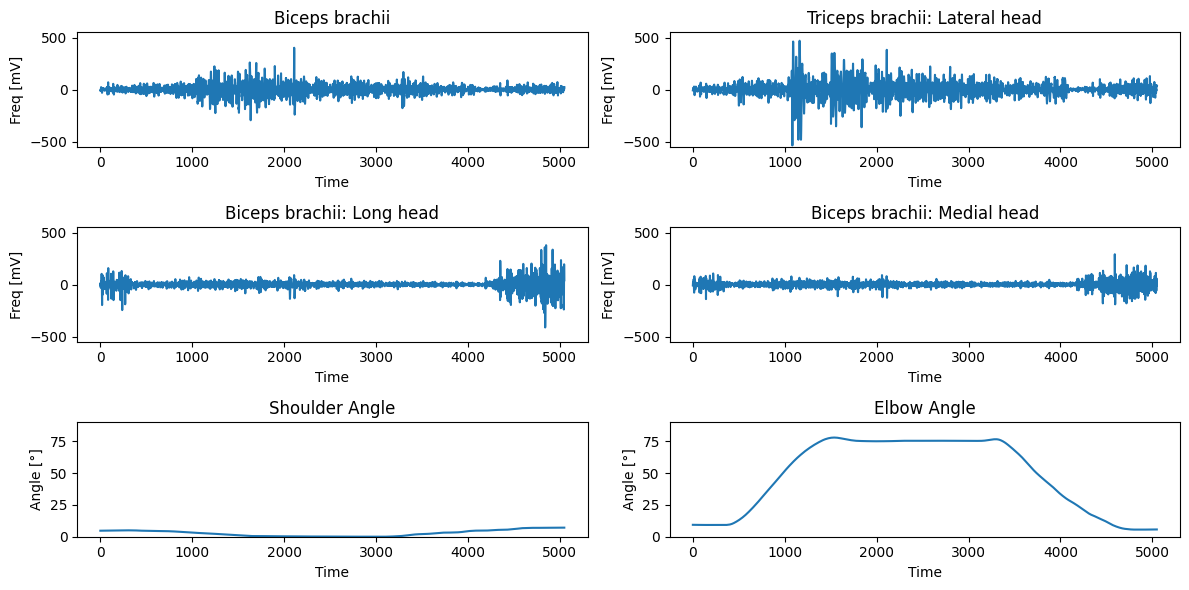

In [ ]:
# Create the figure with desired size
plt.figure(figsize=(12, 6))  # Adjust height as needed

# Plot each line data with labels directly
ylim_emg_l = -550
ylim_emg_h = 550
ylim_imu_l = 0
ylim_imu_h = 90
plt.subplot(3,2,1)
plt.plot(new_light[1][0])
plt.ylim(ylim_emg_l, ylim_emg_h)
plt.xlabel("Time")
plt.ylabel("Freq [mV]")
plt.title("Biceps brachii")
plt.subplot(3,2,2)
plt.plot(new_light[1][1])
plt.ylim(ylim_emg_l, ylim_emg_h)
plt.xlabel("Time")
plt.ylabel("Freq [mV]")
plt.title("Triceps brachii: Lateral head")
plt.subplot(3,2,3)
plt.plot(new_light[1][2])
plt.ylim(ylim_emg_l, ylim_emg_h)
plt.xlabel("Time")
plt.ylabel("Freq [mV]")
plt.title("Biceps brachii: Long head")
plt.subplot(3,2,4)
plt.plot(new_light[1][3])
plt.ylim(ylim_emg_l, ylim_emg_h)
plt.xlabel("Time")
plt.ylabel("Freq [mV]")
plt.title("Biceps brachii: Medial head")
plt.subplot(3,2,5)
plt.plot(new_light[1][4])
plt.ylim(ylim_imu_l, ylim_imu_h)
plt.xlabel("Time")
plt.ylabel("Angle [°]")
plt.title("Shoulder Angle")
plt.subplot(3,2,6)
plt.plot(new_light[1][5])
plt.ylim(ylim_imu_l, ylim_imu_h)
plt.xlabel("Time")
plt.ylabel("Angle [°]")
plt.title("Elbow Angle")

plt.tight_layout()
plt.show()


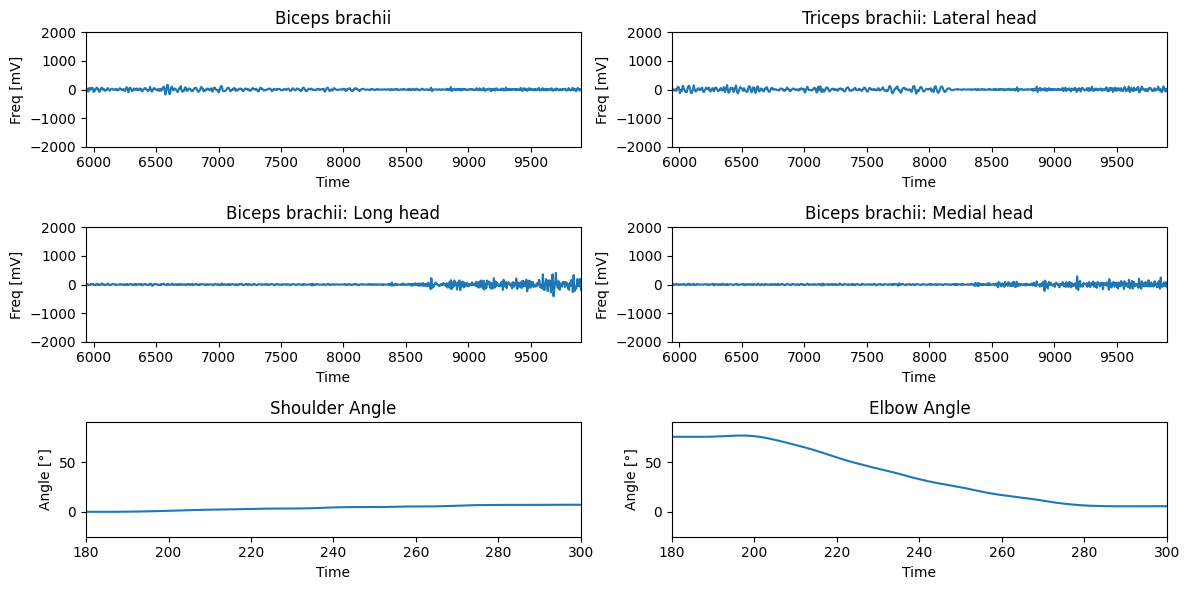

In [ ]:
# Create the figure with desired size
plt.figure(figsize=(12, 6))  # Adjust height as needed

# Plot each line data with labels directly
ylim_emg_l = -2000
ylim_emg_h = 2000
ylim_imu_l = -25
ylim_imu_h = 90
xlim_emg_l = 5940
xlim_emg_h = 9900
xlim_imu_l = 180
xlim_imu_h = 300
plt.subplot(3,2,1)
plt.plot(segmented_parts_konnyuemeles[1][1][0])
plt.ylim(ylim_emg_l, ylim_emg_h)
plt.xlim(xlim_emg_l ,xlim_emg_h)
plt.xlabel("Time")
plt.ylabel("Freq [mV]")
plt.title("Biceps brachii")
plt.subplot(3,2,2)
plt.plot(segmented_parts_konnyuemeles[1][1][1])
plt.ylim(ylim_emg_l, ylim_emg_h)
plt.xlim(xlim_emg_l ,xlim_emg_h)
plt.xlabel("Time")
plt.ylabel("Freq [mV]")
plt.title("Triceps brachii: Lateral head")
plt.subplot(3,2,3)
plt.plot(segmented_parts_konnyuemeles[1][1][2])
plt.ylim(ylim_emg_l, ylim_emg_h)
plt.xlim(xlim_emg_l ,xlim_emg_h)
plt.xlabel("Time")
plt.ylabel("Freq [mV]")
plt.title("Biceps brachii: Long head")
plt.subplot(3,2,4)
plt.plot(segmented_parts_konnyuemeles[1][1][3])
plt.ylim(ylim_emg_l, ylim_emg_h)
plt.xlim(xlim_emg_l ,xlim_emg_h)
plt.xlabel("Time")
plt.ylabel("Freq [mV]")
plt.title("Biceps brachii: Medial head")
plt.subplot(3,2,5)
plt.plot(segmented_parts_konnyuemeles[1][0][0])
plt.ylim(ylim_imu_l, ylim_imu_h)
plt.xlim(xlim_imu_l ,xlim_imu_h)
plt.xlabel("Time")
plt.ylabel("Angle [°]")
plt.title("Shoulder Angle")
plt.subplot(3,2,6)
plt.plot(segmented_parts_konnyuemeles[1][0][1])
plt.ylim(ylim_imu_l, ylim_imu_h)
plt.xlim(xlim_imu_l ,xlim_imu_h)
plt.xlabel("Time")
plt.ylabel("Angle [°]")
plt.title("Elbow Angle")

plt.tight_layout()
plt.show()
